In [8]:
# Reference:
# /exp/rhuang/icefall_align2/egs/librispeech/ASR/ruizhe_hmm/run.ipynb
# /exp/rhuang/icefall_align2/icefall/bpe_graph_compiler.py

In [1]:
import sys
sys.path.append("/scratch4/skhudan1/rhuang25/k2/k2/python/")
sys.path.append("/scratch4/skhudan1/rhuang25/k2/build_debug/lib/")
sys.path.append("/scratch4/skhudan1/rhuang25/icefall/")
sys.path.append("/scratch4/skhudan1/rhuang25/kaldifeat/kaldifeat/python/")
sys.path.append("/scratch4/skhudan1/rhuang25/kaldifeat/build/lib/")

In [2]:
import k2
import sentencepiece as spm
import torch

In [3]:
sp = spm.SentencePieceProcessor()
sp.load("/home/rhuang25/work/icefall/egs/librispeech/ASR/data/lang_bpe_500/bpe.model")

True

In [15]:
texts = ["I DO NOT WANT TO INCUR", "THERE WAS LOVERS LIKE DOGS"]
word_ids_list = sp.encode(texts, out_type=int)
word_ids_list

[[24, 102, 70, 393, 12, 17, 19, 80], [154, 37, 345, 21, 3, 225, 102, 52, 3]]

In [27]:
word_ids_list = [[24, 102, 70, 393, 12, 17, 19, 80], [154, 37, 345, 21, 3, 225, 102, 52, 3]]
word_ids_list = [[24, 102, 70, 393, 12, 12, 17, 19, 80], [154, 37, 345, 21, 3, 225, 102, 52, 3]]
word_ids_list = [[24, 102, 70]]

In [28]:
graphs = k2.ctc_graph(word_ids_list, modified=False, device='cpu')

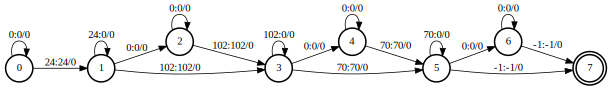

In [38]:
k2.to_dot(graphs[0])

In [30]:
graph = graphs[0]
c_str = k2.to_str_simple(graph)

In [31]:
arcs = c_str.strip().split("\n")
arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
final_state = int(arcs[-1])
arcs = arcs[:-1]
arcs = [tuple(map(int, a.split())) for a in arcs]

In [44]:
def make_factor_transducer(word_id_list):
    fst_graph = k2.ctc_graph([word_id_list], modified=False, device='cpu')[0]

    c_str = k2.to_str_simple(fst_graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])
    
    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]
    # ss, ee, l1, l2, w = arc

    non_eps_nodes = set((arc[1], arc[3]) for arc in arcs if arc[3] != 0 and arc[3] != -1)   # if this node has a non-eps in-coming arc
    arcs += [(0, n, l, l, 0) for n, l in non_eps_nodes if n > 1]

    arcs += [(n, final_state, -1, -1, 0) for n in range(1, final_state - 2)]

    new_arcs = arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    fst = k2.Fsa.from_str(new_arcs, acceptor=False)
    return fst


In [45]:
graph_ft = make_factor_transducer(word_ids_list[0])

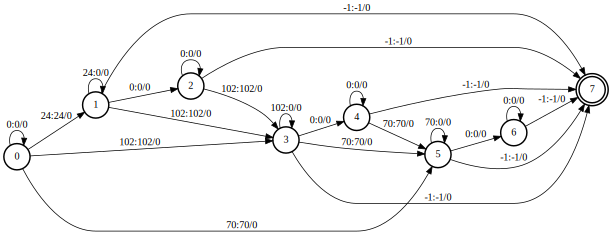

In [46]:
k2.to_dot(graph_ft)